# ACME Happiness Survey 2020

## Summary Notes
- There's not much data here
- once data was cleaned the top columns seem to be order_delivered (X1), courier (X5), and app (X6), and also menu_complete (X3)

- Just removing columns that had high correlation (e.g. app (X6) and order_delivered (X1) )  did not seem to work right away - perhaps with more effort, or featuretools ...

- PCA analysis seemed to pick close to the same columns, but I'm not sure that it really reduced the data by much.
- Pycaret chose GradientBoostingClassifier as the best model
- The PCA dataset and GradientBoostingClassifier did not yield great accuracy - I may be doing something wrong there
- The GradientBoostingClassifier with all the data yielded 62% accuracy

---

<a id='toc'></a>
## Table of Contents

* [Read and Review](#review)
* [Clean Data](#cleanup)
* [Features Heatmap](#heatmap)
* [Correlation to Happy](#correlation)
* [Feature Gain](#gain)
* [Principal Component Analysis](#pca)
* [Logistic Regression](#accuracy)

In [1]:
from ultimate_utils import plot_heatmap
from ultimate_utils import correlate_to_target, plot_correlations
from ultimate_utils import calc_feature_importance

import pandas as pd
import warnings

warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



# Read and Review data <a id='review'></a>

Change column names to something I can remember

| Original name | New name                                        | Description                                                                     : |
|---------------|-------------------------------------------------|-----------------------------------------------------------------------------------|
| Y             | <span style="color:teal">happy</span>           | target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers   |
| X1            | <span style="color:teal">order_delivered</span> | my order was delivered on time                                                    |
| X2            | <span style="color:teal">order_correct</span>   | contents of my order was as I expected                                            |
| X3            | <span style="color:teal">menu_complete</span>   | I ordered everything I wanted to order                                            |
| X4            | <span style="color:teal">price</span>           | I paid a good price for my order                                                  |
| X5            | <span style="color:teal">courier</span>         | I am satisfied with my courier                                                    |
| X6            | <span style="color:teal">app</span>             | the app makes ordering easy for me                                                |


In [2]:
df = pd.read_csv('ACME-HappinessSurvey2020.csv', header=0, names=[
                     'happy', 
                     'order_delivered',
                     'order_correct',
                     'menu_complete',
                     'price',
                     'courier',
                     'app'
                 ])

In [3]:
df.shape

(126, 7)

In [4]:
df.dtypes

happy              int64
order_delivered    int64
order_correct      int64
menu_complete      int64
price              int64
courier            int64
app                int64
dtype: object

In [5]:
df.value_counts()

happy  order_delivered  order_correct  menu_complete  price  courier  app
1      5                1              3              3      4        4      3
                        5              5              5      5        5      2
                        3              3              4      4        5      2
0      5                4              3              3      3        5      2
1      4                1              3              4      4        4      2
                                                                            ..
0      4                5              5              5      1        3      1
                        4              4              4      3        4      1
                                                             1        3      1
                                                      2      5        5      1
1      3                2              4              3      4        4      1
Length: 110, dtype: int64

# Cleanup <a id='cleanup'></a>
### Remove rows with non-numeric values 


In [6]:
df.describe()

,happy,order_delivered,order_correct,menu_complete,price,courier,app
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Feature Correlations  <a id='heatmap'></a>

- order_delivered, courier, and price correlate to happy
- app correlates to order_delivered and inversely to order_correct to some extent
- 

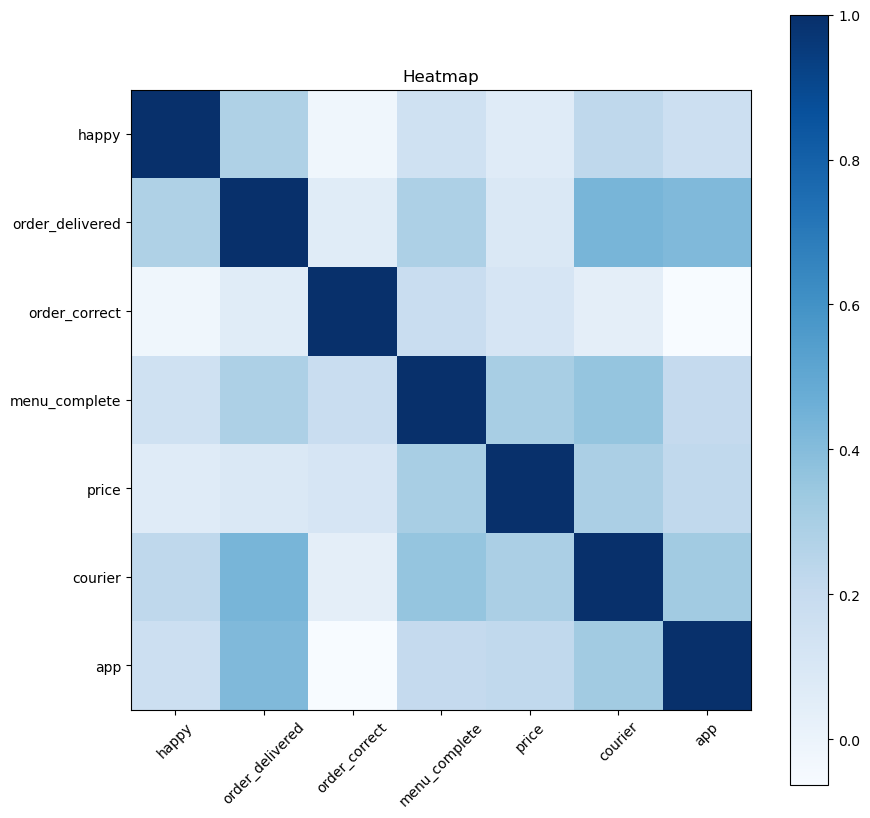

In [7]:
plot_heatmap(df, cmap='Blues', label_fontsize=10, method='pearson')

# Feature Selection   <a id='correlation'></a>

## Kendall Correlation to target
Which features correlate best to the happy target?

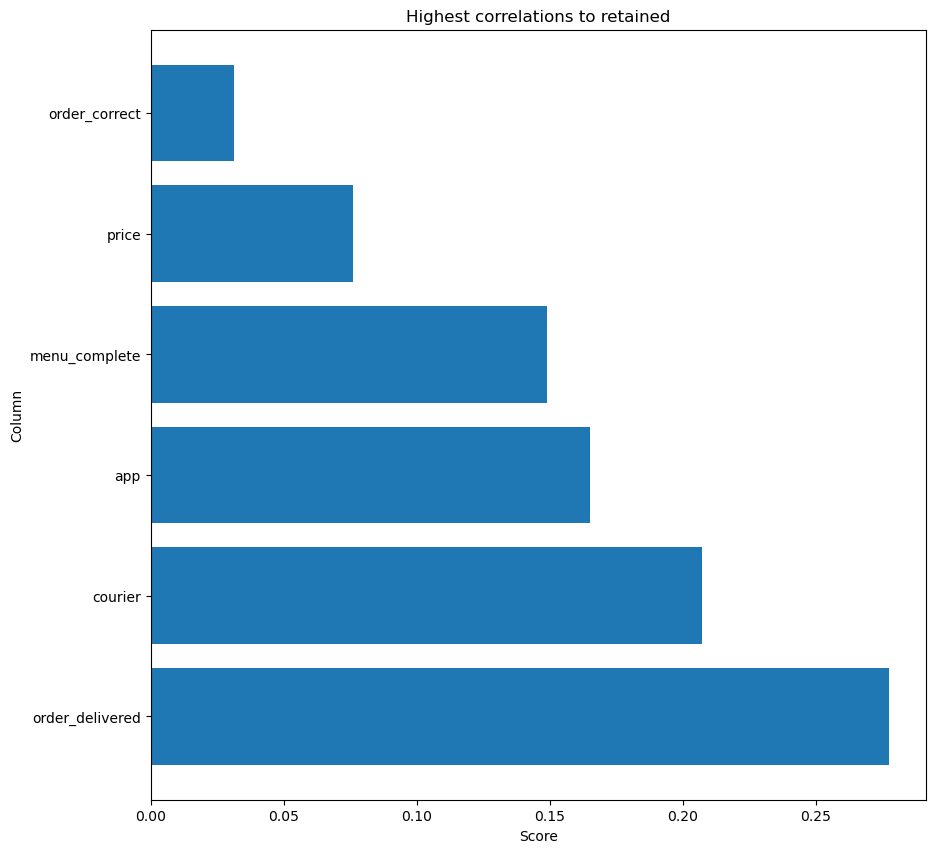

In [8]:
top_correlations, set_correlations = correlate_to_target(df, 'happy', 30, method='kendall')
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Highest correlations to retained')

# Calculated Gain -- xgboost  <a id='gain'></a>

Which features does xgboost think important?

In [9]:
X = df.copy()
y = X.pop('happy')

top_features, set_features = calc_feature_importance(X, y, top_n=30)

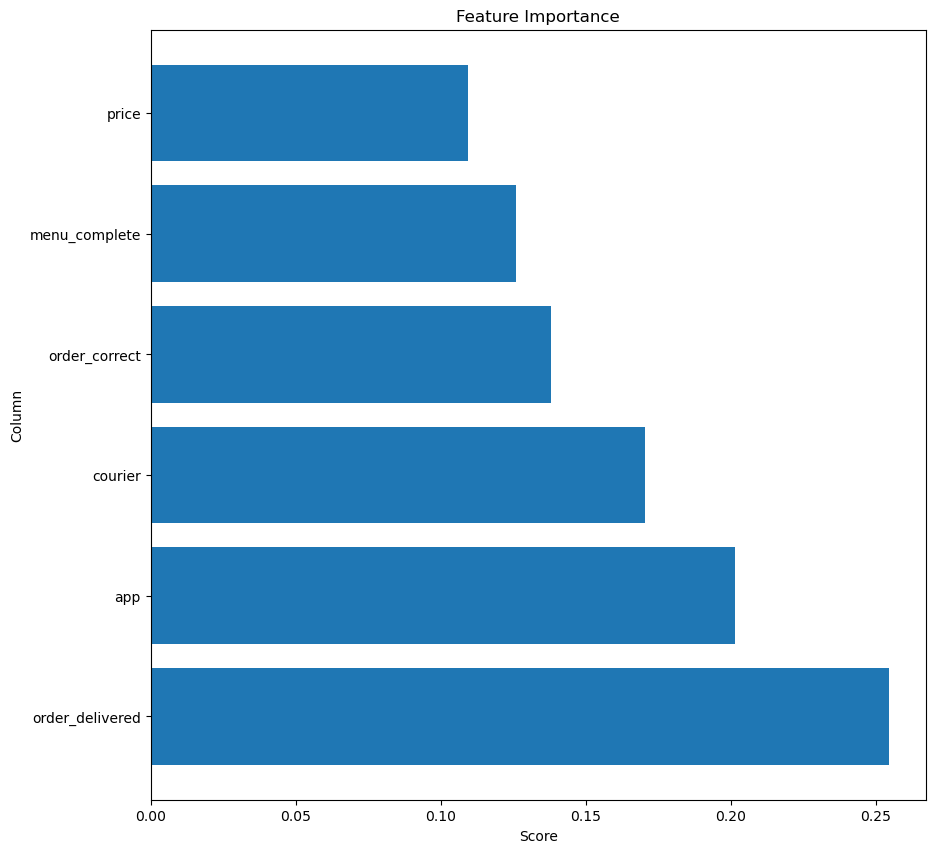

In [10]:
plot_correlations(
    top_features['corr'],
    top_features['y'], "Feature Importance")

## PCA Analysis  <a id='pca'></a>
Can we reduce dimensionality and increase accuracy with PCA analysis

In [11]:
features = df[['order_delivered', 'order_correct', 'menu_complete', 'price',
       'courier', 'app']]

target = df['happy']


# y = target.values.ravel()
# y.shape

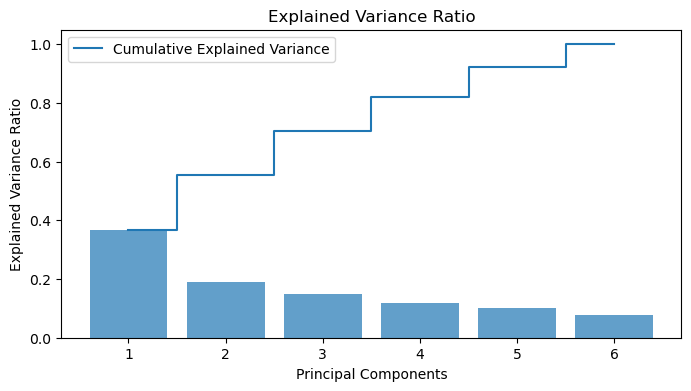

Number of Components Selected: 6
        PC1       PC2       PC3       PC4       PC5       PC6
0  1.629286  1.033176 -0.768319  0.713552 -0.674095 -0.252497
1  0.971625  1.092609 -2.039079 -0.665219  0.979748 -0.056559
2 -0.108811 -0.624596  1.224703  0.838631 -0.513365  0.115917
3 -0.217184  0.040060  1.677723  1.190830 -0.413043 -0.018635
4 -0.217184  0.040060  1.677723  1.190830 -0.413043 -0.018635
Loadings:
                      PC1       PC2       PC3       PC4       PC5       PC6
order_delivered -0.467272 -0.283589  0.482292 -0.003015  0.112441  0.675260
order_correct   -0.120344  0.738073  0.503060  0.391102  0.111404 -0.149414
menu_complete   -0.443685  0.316632 -0.029273 -0.530419 -0.646840 -0.047801
price           -0.358668  0.328158 -0.716117  0.282488  0.179898  0.372401
courier         -0.507255 -0.084543 -0.013436 -0.340608  0.622090 -0.482032
app             -0.429380 -0.399668 -0.021544  0.608171 -0.370385 -0.385197


In [12]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Sample data
np.random.seed(0)
data = np.random.rand(100, 5)  # 100 samples with 5 features




# Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of components to retain (e.g., 95% of variance)
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_data)

# Access the loadings (contributions of original features to principal components)
loadings = pca.components_

# Create a DataFrame of the principal components with feature names
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, n_components + 1)])

# Create a DataFrame of loadings with feature names
loadings_df = pd.DataFrame(data=loadings.T, columns=[f'PC{i}' for i in range(1, n_components + 1)], index=features.columns)

# Plot explained variance ratio
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.title('Explained Variance Ratio')
plt.show()

# Print the number of components selected, the DataFrame of principal components, and the loadings
print(f'Number of Components Selected: {n_components}')
print(principal_df.head())
print("Loadings:")
print(loadings_df)


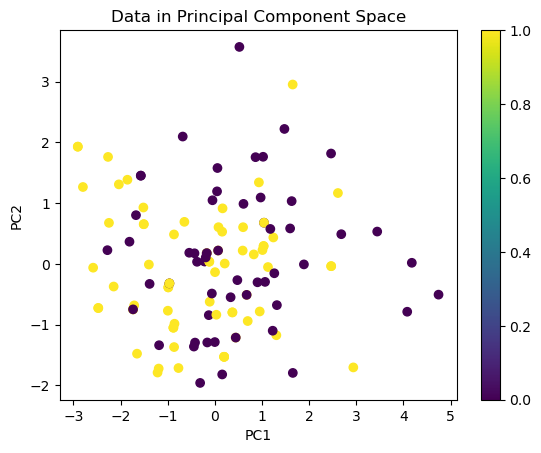

In [13]:
import matplotlib.pyplot as plt

plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data in Principal Component Space')
plt.colorbar()
plt.show()


## Accuracy  <a id='accuracy'></a>

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model using the principal components as features  --- and now without the PCA data
model = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=3180, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
model.fit(X_train, y_train)

# Evaluate 
accuracy = model.score(X_test, y_test)

print(accuracy)

0.6153846153846154
